In [ ]:
%pip install requirements.txt

In [19]:
import torch
from tqdm import tqdm
from utils import connectomes_data_loader, anti_vectorize
from torch.utils.data import TensorDataset, DataLoader, Subset, SubsetRandomSampler
import yaml
import wandb
from models.DDPM_Schedule import DDPM
from models.unet import ContextUnet
import random
import numpy as np
import pandas as pd
from MatrixVectorizer import MatrixVectorizer

In [7]:
#config
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
if config["Wandb"]["use_wandb"]:

    wandb.login(key=config["Wandb"]["key"])

#data
source_data=config["Data"]["morphological_data"]
target_data=config["Data"]["functional_data"]
source_data = np.array(pd.read_csv(source_data))
target_data = np.array(pd.read_csv(target_data))
source_data = anti_vectorize(source_data, h=False, num_nodes=config["Diffusion"]["source_dim"])
target_data = anti_vectorize(target_data, h=True, num_nodes=config["Diffusion"]["target_dim"])
source_data = torch.from_numpy(source_data).float()
target_data = torch.from_numpy(target_data).float()
source_data[source_data < 0] = 0
target_data[target_data < 0] = 0
all_ds = TensorDataset(target_data, source_data)

train_loader = DataLoader(all_ds, batch_size=config["Diffusion"]["batch_size"], shuffle=False)

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#train
if config["Wandb"]["use_wandb"]:

        if wandb.run is not None:
            wandb.finish()

        wandb.init(project="ConDiff", name=f"fold_{fold + 1}_Diffusion_Image", config=config)


nn = ContextUnet(in_channels=1,
                     n_feat=config["Diffusion"]["n_feat"],
                     n_classes=config["Diffusion"]["source_dim"]**2)

model = DDPM(denoising_model=nn,
                    beta1=config["Diffusion"]["beta1"],
                    beta2=config["Diffusion"]["beta2"],
                    n_T=config["Diffusion"]["n_T"],
                    drop_prob=config["Diffusion"]["dropout_prob"],
                    lr=config["Diffusion"]["lr"])

n_epoch = config["Diffusion"]["epochs"]

model.to(device)

lr=0.001

optim = torch.optim.Adam(model.parameters(), lr=lr)

losses = []

for ep in range(n_epoch):
    print(f'epoch {ep}')
    model.train()

    pbar = tqdm(train_loader)
    loss_ema = None
    optim.param_groups[0]['lr'] = config["Diffusion"]["lr"] * (1 - ep / n_epoch)

    for x, c in pbar:
        optim.zero_grad()
        x = x.unsqueeze(1).to(device)
        c = c.to(device)
        loss = model(x, c)
        if config["Wandb"]["use_wandb"]:
            wandb.log({"train_loss": loss,
                        "epoch": ep})
        loss.backward()
        loss_ema = loss.item()
        losses.append(loss_ema)

        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

with torch.no_grad():
    with open(f'./results/Diffusion_Train/full_lr{lr}.ckpt', "wb") as f:
        torch.save(model.state_dict(), f)


epoch 0


loss: 0.5060: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


epoch 1


loss: 0.2805: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 2


loss: 0.0957: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 3


loss: 0.1471: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 4


loss: 0.0469: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 5


loss: 0.0926: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


epoch 6


loss: 0.0873: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 7


loss: 0.6711: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 8


loss: 0.2125: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 9


loss: 0.0703: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 10


loss: 0.0983: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 11


loss: 0.0470: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 12


loss: 0.0599: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 13


loss: 0.2023: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 14


loss: 0.0319: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 15


loss: 0.0466: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 16


loss: 0.0501: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 17


loss: 0.1961: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 18


loss: 0.1148: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 19


loss: 0.0918: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 20


loss: 0.1075: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


epoch 21


loss: 0.2348: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 22


loss: 0.0991: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 23


loss: 0.1203: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 24


loss: 0.0904: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 25


loss: 0.1126: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 26


loss: 0.0510: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 27


loss: 0.1261: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 28


loss: 0.2103: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


epoch 29


loss: 0.0640: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 30


loss: 0.0525: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


epoch 31


loss: 0.0568: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 32


loss: 0.1065: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 33


loss: 0.0379: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 34


loss: 0.2161: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 35


loss: 0.1523: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


epoch 36


loss: 0.1974: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 37


loss: 0.2045: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 38


loss: 0.0255: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 39


loss: 0.1849: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 40


loss: 0.1953: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 41


loss: 0.0561: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 42


loss: 0.1244: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 43


loss: 0.1114: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 44


loss: 0.1422: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 45


loss: 0.0413: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 46


loss: 0.0192: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 47


loss: 0.0954: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 48


loss: 0.1159: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 49


loss: 0.0955: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 50


loss: 0.0517: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 51


loss: 0.1015: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 52


loss: 0.1941: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 53


loss: 0.0630: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


epoch 54


loss: 0.0894: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 55


loss: 0.2932: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 56


loss: 0.0480: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 57


loss: 0.0937: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 58


loss: 0.0321: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 59


loss: 0.0868: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


epoch 60


loss: 0.2782: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 61


loss: 0.0395: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 62


loss: 0.0514: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 63


loss: 0.0705: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 64


loss: 0.0431: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 65


loss: 0.0596: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 66


loss: 0.0616: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


epoch 67


loss: 0.0275: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 68


loss: 0.0819: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 69


loss: 0.0714: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 70


loss: 0.1380: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 71


loss: 0.0396: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 72


loss: 0.0279: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 73


loss: 0.0442: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 74


loss: 0.1766: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 75


loss: 0.0581: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 76


loss: 0.1018: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 77


loss: 0.2404: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 78


loss: 0.0331: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 79


loss: 0.0597: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 80


loss: 0.0580: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 81


loss: 0.0529: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 82


loss: 0.1557: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 83


loss: 0.0746: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


epoch 84


loss: 0.1294: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 85


loss: 0.0519: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


epoch 86


loss: 0.0610: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


epoch 87


loss: 0.0698: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 88


loss: 0.1619: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


epoch 89


loss: 0.0221: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 90


loss: 0.1523: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 91


loss: 0.0404: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 92


loss: 0.0239: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 93


loss: 0.1551: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 94


loss: 0.0186: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 95


loss: 0.0712: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


epoch 96


loss: 0.1049: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


epoch 97


loss: 0.0392: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


epoch 98


loss: 0.0484: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


epoch 99


loss: 0.0480: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


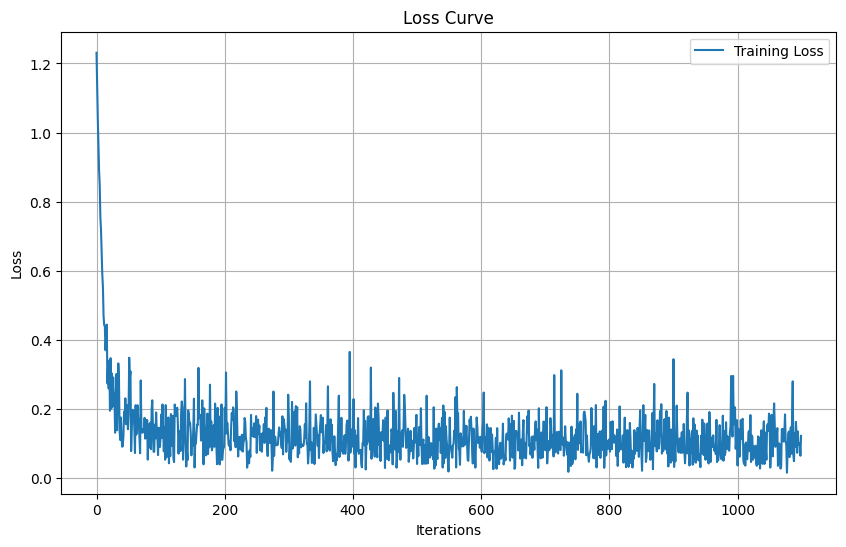

In [4]:
#lr=0.0001
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

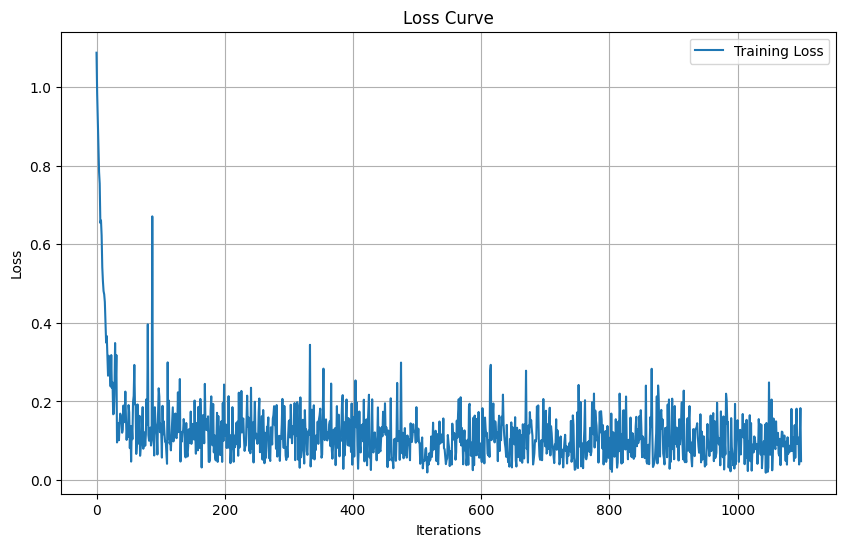

In [8]:
#lr=0.001
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

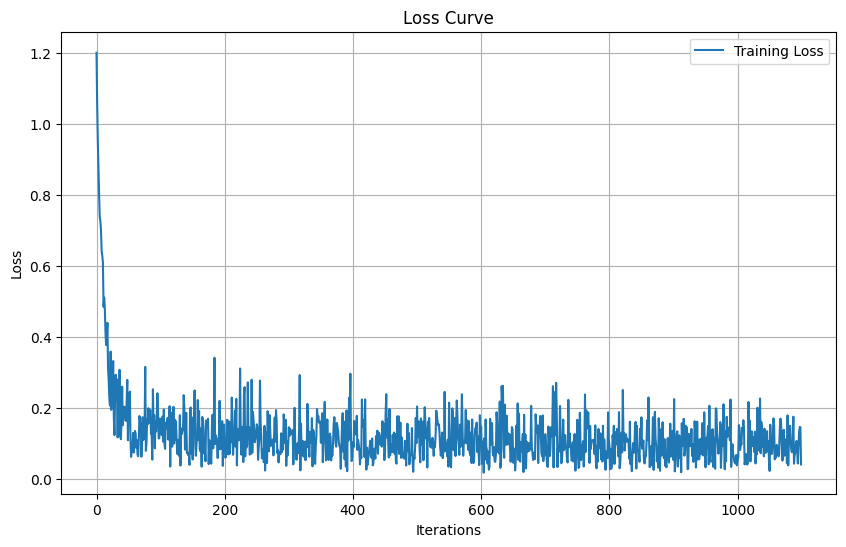

In [6]:
#lr=0.0005
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
#config
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
if config["Wandb"]["use_wandb"]:

    wandb.login(key=config["Wandb"]["key"])

#data
test_data=config["Data"]["test_data"]
test_data = np.array(pd.read_csv(test_data))
test_data = anti_vectorize(test_data, h=False, num_nodes=config["Diffusion"]["source_dim"])
test_data = torch.from_numpy(test_data).float()
test_data[test_data < 0] = 0
fake_ds = TensorDataset(test_data, torch.zeros_like(test_data))
test_loader = DataLoader(fake_ds, batch_size=config["Diffusion"]["batch_size"], shuffle=False)

g = config["Sampling"]["guidance"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
source_dim = config["Sampling"]["source_dim"]**2
n_feat = config["Sampling"]["n_feat"]

ddpm = DDPM(denoising_model=ContextUnet(in_channels=1,
                                        n_feat=n_feat,
                                        n_classes=source_dim,
                                        three_layers=config["Sampling"]["three_layers"]),
            beta1=config["Diffusion"]["beta1"],
            beta2=config["Diffusion"]["beta2"],
            n_T=config["Diffusion"]["n_T"],
            drop_prob=config["Diffusion"]["dropout_prob"])
ddpm.to(device)
ddpm.load_state_dict(torch.load(f"results/Diffusion_Train/full.ckpt", map_location=device))
ddpm.eval()
dl = test_loader
fin = []
with torch.no_grad():
    for c in tqdm(dl):
        c = c[0].to(device)
        x_gen = ddpm.sample(c.shape[0], (1, 268, 268), device, c, guide_w=g) #EDITED Moritz
        fin.append(x_gen.detach().cpu())





  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:30<09:01, 90.19s/it]

 29%|██▊       | 2/7 [03:00<07:30, 90.14s/it]

 43%|████▎     | 3/7 [04:30<06:00, 90.13s/it]

 57%|█████▋    | 4/7 [06:00<04:30, 90.12s/it]

 71%|███████▏  | 5/7 [07:30<03:00, 90.13s/it]

 86%|████████▌ | 6/7 [09:00<01:30, 90.13s/it]

100%|██████████| 7/7 [10:30<00:00, 90.14s/it]


In [27]:
def generate_submission_file(prediction_tensors, filepath): 
    """
    Recommended file path is 'submission_files/xxxxxx.csv'

    input:
    - prediction_tensor: torch.tensor should be of shape [N,268,268] in same order as lr_test.csv
    """
    vectorizer = MatrixVectorizer()
    numpy_list = [prediction_tensors[i] for i in range(prediction_tensors.shape[0])]
    all_vectorized = np.concatenate([vectorizer.vectorize(matrix) for matrix in prediction_tensors])
    print(all_vectorized.shape)
    meltedDF = pd.DataFrame(all_vectorized.flatten())
    print(meltedDF.shape)
    meltedDF.to_csv(filepath, index=False)
    meltedDF.columns = ['ID','Predicted']
    return meltedDF

#concat batches
fin_concat = torch.concat(fin, dim=0)

#squeeze to 3 dims
fin_squeezed = fin_concat.squeeze(1)

#melt and write
meltedDF = generate_submission_file(fin_squeezed, './results/test_submission_file.csv')

meltedDF

(4007136,)
(4007136, 1)


ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [48]:
#3FCW
from evaluation_fn import evaluate_predictions
import pickle

g_d = config["Sampling"]["guidance"]

g = [f'results/Diffusion_Sample/gen_0_{g_d}.pkl',
     f'results/Diffusion_Sample/gen_1_{g_d}.pkl',
     f'results/Diffusion_Sample/gen_2_{g_d}.pkl']

t = [f'results/Diffusion_Sample/target_0_{g_d}.pkl',
     f'results/Diffusion_Sample/target_1_{g_d}.pkl',
     f'results/Diffusion_Sample/target_2_{g_d}.pkl'
     ]

def post(x):

    for i in range(x.shape[1]):
        x[:, i, i] = 1

    x[x < 0] = 0
    x[x > 1] = 1

    x_tr = torch.transpose(x, 1, 2)
    x = (x + x_tr) / 2

    return x

def stacking(x):
    x_main = x[0].squeeze(1)
    for i in range(1, len(x)):
        cur = x[i].squeeze(1)
        x_main = torch.cat((x_main, cur), dim=0)
    return x_main


def stacking_targets(x):
    x_main = x[0]
    for i in range(1, len(x)):
        cur = x[i]
        x_main = torch.cat((x_main, cur), dim=0)
    return x_main



for fold in range(3):

    gen_f = g[fold]
    target_f = t[fold]

    with open(gen_f, "rb") as f:
        generated = pickle.load(f)

    with open(target_f, "rb") as f:
        targets = pickle.load(f)

    generated = stacking(generated).detach()

    targets = stacking_targets(targets).detach()

    generated = post(generated)

    targets = post(targets)

    evaluate_predictions(generated, targets)
